In [1]:
import sys
import tempfile

import h5py
import numpy as np

from versioned_hdf5 import VersionedHDF5File

shape = (20_000, 20_000)  # ~3 GiB
chunks = (100, 100)  # 40k x 78 kib chunks
# chunks = (2_000, 2_000)  # 100 x 30 MiB chunks
n_chunks = int(np.prod(shape) // np.prod(chunks))
print(f"{n_chunks=}")

tmpdir = tempfile.TemporaryDirectory()
path = f"{tmpdir.name}/data.h5"

with h5py.File(path, "w") as f:
    vf = VersionedHDF5File(f)
    with vf.stage_version("r0") as sv:
        sv.create_dataset(
            "value",
            data=np.arange(np.prod(shape)).reshape(shape),
            chunks=(chunks),
            maxshape=(None, None),
        )

n_chunks=40000


In [2]:
f = h5py.File(path, "r+")
vf = VersionedHDF5File(f)
ctx = vf.stage_version("r1")
sv = ctx.__enter__()
dset = sv["value"]
%time dset.dataset.staged_changes._setitem_plan(slice(None, None, 2))
dset[::2] = 123

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 177 ms


In [3]:
dset.dataset.staged_changes.slabs[1].shape

(4000000, 100)

In [4]:
dset.dataset.staged_changes.slabs[2].shape

(4000000, 100)

In [5]:
%load_ext pyinstrument

False

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:56:03  Samples:  12122
 /_//_/// /_\ / //_// / //_'/ //     Duration: 12.902    CPU time: 13.049
/   _/                      v5.0.0

Cell [6]

12.902 <module>  /tmp/ipykernel_86632/4274702155.py:1
`- 12.902 _GeneratorContextManager.__exit__  contextlib.py:141
   `- 12.902 VersionedHDF5File.stage_version  versioned_hdf5/api.py:268
      `- 12.889 commit_version  versioned_hdf5/versions.py:71
         |- 8.744 write_dataset_chunks  versioned_hdf5/backend.py:355
         |  |- 5.675 Dataset.__setitem__  h5py/_hl/dataset.py:871
         |  |     [7 frames hidden]  h5py
         |  |        4.160 [self]  h5py/_hl/dataset.py
         |  |- 2.039 Hashtable.hash  versioned_hdf5/hashtable.py:120
         |  |  |- 1.733 openssl_sha256  <built-in>
         |  |  `- 0.176 memoryview.tobytes  <built-in>
         |  |- 0.384 [self]  versioned_hdf5/backend.py
         |  `- 0.379 Hashtable.__setitem__  versioned_hdf5/hashtable.py:215
         |- 2.797 create_virtual_dataset  versioned_hdf5/backend.py:438
         |  |- 0.803 [self]  versioned_hdf5/backend.py
         |  |- 0.511 select  h5py/_hl/selections.py:19
         |  |- 0.456 Group.create_virtual_dataset  h5py/_hl/group.py:188
         |  |     [2 frames hidden]  h5py
         |  |- 0.241 Dataset.shape  h5py/_hl/dataset.py:485
         |  `- 0.230 Tuple.isempty  ndindex/tuple.py:672
         |        [2 frames hidden]  ndindex
         `- 1.344 InMemoryDataset.data_dict  versioned_hdf5/wrappers.py:631
            `- 1.344 _staged_changes_to_data_dict  versioned_hdf5/wrappers.py:1230
               |- 0.920 NDIndexConstructor.__call__  ndindex/ndindex.py:112
               |     [3 frames hidden]  ndindex
               `- 0.264 [self]  versioned_hdf5/wrappers.py
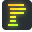

In [6]:
%%pyinstrument
ctx.__exit__(None, None, None)

In [ ]:
%time dset.dataset.staged_changes.slabs[1].resize((n_chunks * 2 * chunks[0], chunks[1]))

In [ ]:
%time dset.dataset.staged_changes.slabs[1][n_chunks * chunks[0]:] = dset.dataset.staged_changes.slabs[2]

In [ ]:
from versioned_hdf5.slicetools import read_many_slices, np_hsize_t

params = np.empty((n_chunks, 5, 2), dtype=np_hsize_t)
params[:, 0, 0] = np.arange(0, n_chunks * chunks[0], chunks[0])  # src_start[0]
params[:, 1, 0] = np.arange(n_chunks * chunks[0], 2 * n_chunks * chunks[0], chunks[0])  # dst_start[0]
params[:, 0:2, 1] = 0  #src_start[1], dst_start[1]
params[:, 2, :] = chunks  # count[*]
params[:, 3:5, :] = 1  # src_stride[*], dst_stride[*]

In [ ]:
from versioned_hdf5.slicetools import read_many_slices, np_hsize_t

params = np.empty((1, 5, 2), dtype=np_hsize_t)
params[0, 0, 0] = 0  # src_start[0]
params[0, 1, 0] = n_chunks * chunks[0]  # dst_start[0]
params[0, 0:2, 1] = 0  #src_start[1], dst_start[1]
params[0, 2, 0] = n_chunks * chunks[0]  # count[0]
params[0, 2, 1] = chunks[1]  # count[1]
params[0, 3:5, :] = 1  # src_stride[*], dst_stride[*]

In [ ]:
%%time
read_many_slices(
    src=dset.dataset.staged_changes.slabs[2],
    dst=dset.dataset.staged_changes.slabs[1],
    src_start=params[:, 0, :],
    dst_start=params[:, 1, :],
    count=params[:, 2, :],
    src_stride=params[:, 3, :],
    dst_stride=params[:, 4, :],
    fast=True,
)

In [ ]:
np.testing.assert_array_equal(
    dset.dataset.staged_changes.slabs[1][n_chunks * chunks[0]:],
    dset.dataset.staged_changes.slabs[2],
)